<a href="https://www.kaggle.com/code/xuanbao01/khaipha-btl?scriptVersionId=191763714" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import thư viện

In [1]:
import pandas as pd
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import sklearn
from collections import Counter

from sklearn.feature_selection import SelectKBest, chi2

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

# model
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


import scikitplot as skplt




# Load dữ liệu

In [4]:
train_df = pd.read_csv("/kaggle/input/telecom/5.telecom_train.csv")
test_df = pd.read_csv("/kaggle/input/telecom/4.telecom_test.csv")
train_df = train_df[train_df["Customer Status"] != "Joined"]

train_df = train_df.drop(["Churn Category", "Churn Reason"], axis=1)
test_df = test_df.drop(["Churn Category", "Churn Reason"], axis=1)

# 2. Hiểu dữ liệu

## 2.1 Phân tích chung

### 2.1.1 Phân tích đơn biến

In [ ]:
train_df.describe()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Replace infinite values with NaN
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Select numeric columns
numeric_columns = train_df.select_dtypes(include=['int64', 'float64']).columns

# Determine the number of numeric variables
num_vars = len(numeric_columns)
num_cols = 3  # Number of columns in the grid
num_rows = (num_vars + num_cols - 1) // num_cols  # Number of rows in the grid

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Iterate through numeric variables and plot histograms
for i, column in enumerate(numeric_columns):
    row = i // num_cols
    col = i % num_cols
    sns.histplot(train_df[column].dropna(), kde=True, ax=axes[row, col])
    axes[row, col].set_title(f'Histogram of {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Frequency')

# Remove any empty subplots if the number of variables is not enough to fill the grid
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes[j // num_cols, j % num_cols])

plt.tight_layout()
plt.show()


In [ ]:
# categorical feature
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Giả sử train_df đã được tải vào
# Chọn các cột kiểu object (categorical)
categorical_columns = train_df.select_dtypes(include=['object']).columns

# Xác định số lượng biến phân loại
num_vars = len(categorical_columns)
num_cols = 3  # Số cột của lưới
num_rows = (num_vars + num_cols - 1) // num_cols  # Số hàng của lưới

# Tạo các biểu đồ con
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Duyệt qua các biến phân loại và vẽ biểu đồ
for i, column in enumerate(categorical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.countplot(data=train_df, x=column, order=train_df[column].value_counts().index, ax=axes[row, col])
    axes[row, col].set_title(f'Bar Plot of {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Count')
    axes[row, col].tick_params(axis='x', rotation=45)

# Xóa các biểu đồ phụ nếu số biến không đủ để lấp đầy toàn bộ lưới
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes[j // num_cols, j % num_cols])

plt.tight_layout()
plt.show()


### 2.1.2 Phân tích đa biến

In [ ]:
import pandas as pd

# Ma trận tương quan
corr_matrix = train_df[numeric_columns].corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
#phan bo perimeter voi moi class
sns.scatterplot(x=train_df['Tenure in Months'],y=train_df["Total Revenue"],hue=train_df["Customer Status"],palette='Paired')

In [ ]:
#phan bo perimeter voi moi class
sns.scatterplot(x=train_df['Monthly Charge'],y=train_df["Total Charges"],hue=train_df["Customer Status"],palette='Paired')

# 3. Chuẩn bị dữ liệu

## 3.1 Làm sạch dữ liệu

In [5]:
train_df = train_df[train_df["Customer Status"] != "Joined"]
train_df.reset_index(drop=True, inplace=True)

test_df = test_df[test_df["Customer Status"] != "Joined"]
test_df.reset_index(drop=True, inplace=True)

mode_offer = train_df['Offer'].mode().iloc[0]
train_df['Offer'] = train_df['Offer'].fillna("No")
test_df['Offer'] = test_df["Offer"].fillna("No")


### 3.1.1 Xử lý dữ liệu bị thiếu

In [6]:
phone_cols_num = ["Avg Monthly Long Distance Charges"]
phone_cols_cat = ["Multiple Lines"]

internet_cols_num = ["Avg Monthly GB Download"]
internet_cols_cat = [seriesName for seriesName, series in train_df.iloc[:,16:26].items() if series.dtype == "object"]

train_df[phone_cols_num] = train_df[phone_cols_num].fillna(0)
train_df[phone_cols_cat] = train_df[phone_cols_cat].fillna("No")
train_df[internet_cols_num] = train_df[internet_cols_num].fillna(0)
train_df[internet_cols_cat] = train_df[internet_cols_cat].fillna("No")

test_df[phone_cols_num] = test_df[phone_cols_num].fillna(0)
test_df[phone_cols_cat] = test_df[phone_cols_cat].fillna("No")
test_df[internet_cols_num] = test_df[internet_cols_num].fillna(0)
test_df[internet_cols_cat] = test_df[internet_cols_cat].fillna("No")

### 3.1.2 Xử lý giá trị ngoại lệ

In [101]:
import pandas as pd
from typing import Tuple
from sklearn.base import BaseEstimator, TransformerMixin

def find_boxplot_boundaries(col: pd.Series, whisker_coeff: float = 1.5) -> Tuple[float, float]:

    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - whisker_coeff * IQR
    upper = Q3 + whisker_coeff * IQR
    return lower, upper

class BoxplotOutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, whisker_coeff: float = 1.5):
        self.whisker = whisker_coeff
        self.lower = None
        self.upper = None

    def fit(self, X: pd.Series):
        self.lower, self.upper = find_boxplot_boundaries(X, self.whisker)
        return self

    def transform(self, X: pd.Series) -> pd.Series:
        return X.clip(self.lower, self.upper)

for seriesName, series in train_df.items():
    if series.dtype != "object":
        clipper = BoxplotOutlierClipper()
        train_df[seriesName] = clipper.fit_transform(series)    


## 3.2 Chuyển đổi dữ liệu

In [7]:

class_dict = {'Churned': 0, 'Stayed': 1}


X_train = train_df.drop("Customer Status", axis = 1)
y_train = train_df['Customer Status'].replace(class_dict)

X_test = test_df.drop("Customer Status", axis = 1)
y_test = test_df['Customer Status'].replace(class_dict)

/tmp/ipykernel_33/2750210209.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = train_df['Customer Status'].replace(class_dict)
/tmp/ipykernel_33/2750210209.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test = test_df['Customer Status'].replace(class_dict)


### 3.2.1 Normalization

In [8]:
# normalization 
from sklearn.preprocessing import MinMaxScaler, StandardScaler

numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]
scaler = StandardScaler()
scaler.fit(X_train[numerical_cols])

X_train[numerical_cols] = scaler.transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

### 3.2.2 Encoding

In [136]:
low_cardinality_cols = [cname for cname in X_train.columns if X_train[cname].nunique() < 10 and 
                        X_train[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numerical_cols
X_train = X_train[my_cols].copy()
X_test = X_test[my_cols].copy()

# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
X_train[object_cols] = ordinal_encoder.fit_transform(X_train[object_cols])
X_test[object_cols] = ordinal_encoder.transform(X_test[object_cols])


In [9]:
# one hot encoding
from sklearn.preprocessing import OneHotEncoder

low_cardinality_cols = [cname for cname in X_train.columns if X_train[cname].nunique() < 10 and 
                        X_train[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numerical_cols
X_train = X_train[my_cols].copy()
X_test = X_test[my_cols].copy()

# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_test[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_test.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_test.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

# Ensure all columns have string type
OH_X_train.columns = OH_X_train.columns.astype(str)
OH_X_valid.columns = OH_X_valid.columns.astype(str)

X_train, X_test = OH_X_train, OH_X_valid


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# 4. Huấn luyện mô hình

## 4.1 Cân bằng dữ liệu

In [10]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SVMSMOTE


ros = SVMSMOTE()
X_train, y_train = ros.fit_resample(X_train, y_train)

## 4.2 Lựa chọn & trích xuất đặc trưng

### 4.2.1 Lựa chọn đặc trưng

#### Hệ số tương quan

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

def evaluate(model, x_test, y_test):
    pred = model.predict(x_test)
    acc = accuracy_score(y_test, pred)
    print("ACC: ", acc)
    print(classification_report(y_test,pred))
    return pred



# Apply SelectKBest to extract top k features
for i in range(5):
    print(i)
    selector = SelectKBest(chi2, k=i*10+2)
    X_train_selected = selector.fit_transform(X_train, y_train)

    selected_features = selector.get_support(indices=True)
    X_train_selected = X_train.iloc[:, selected_features]
    X_test_selected = X_test.iloc[:, selected_features]
    rfc = RandomForestClassifier(n_estimators=110,max_features='sqrt',max_depth=40)

    rfc.fit(X_train_selected, y_train)
    pred = evaluate(rfc, X_test_selected, y_test)


#### Lựa chọn từ mô hình

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

# Assuming train_df, X_train, y_train, X_test, y_test are already defined
def evaluate(model, x_test, y_test):
    pred = model.predict(x_test)
    acc = accuracy_score(y_test, pred)
    print("ACC: ", acc)
    print(classification_report(y_test,pred))
    return pred

def visualize_result(model, x_test, y_test):
    y_pred = model.predict(x_test)
    sns.heatmap(confusion_matrix(y_test,y_pred),cmap='Blues',annot=True,linewidths=2,linecolor='white')

# Train the LightGBM model
model_fi = lgb.LGBMClassifier()
model_fi.fit(X_train, y_train)

lgbm_scores = model_fi.feature_importances_

# Ensure the columns in X_train are being used for feature importance
lgbm_feats_score = list(zip(X_train.columns, lgbm_scores))
lgbm_feats_score.sort(key=lambda x: -x[1])
for j in range(57):
    print(j)
    lgbm_top_20feats = [i[0] for i in lgbm_feats_score][:j+1]
    
#     rfc = RandomForestClassifier(n_estimators=110,max_features='sqrt',max_depth=40)
#     rfc.fit(X_train[lgbm_top_20feats],y_train)
#     pred = evaluate(rfc, X_test[lgbm_top_20feats], y_test)
    sup = SVC(C=2,gamma='auto',kernel='rbf')
    sup.fit(X_train[lgbm_top_20feats],y_train)

    pred = evaluate(sup, X_test[lgbm_top_20feats], y_test)

#     clf = LogisticRegression(random_state=0).fit(X_train[lgbm_top_20feats], y_train)
#     evaluate(clf, X_train[lgbm_top_20feats], y_train)
#     visualize_result(clf, X_test[lgbm_top_20feats], y_test)



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3663, number of negative: 3663
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9958
[LightGBM] [Info] Number of data points in the train set: 7326, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
0
ACC:  0.731994459833795
              precision    recall  f1-score   support

           0       0.50      0.68      0.58       387
           1       0.87      0.75      0.80      1057

    accuracy                           0.73      1444
   macro avg       0.68      0.72      0.69      1444
weighted avg       0.77      0.73      0.74      1444

1
ACC:  0.7486149584487535
              precision    recall  f1-sc

### 4.2.2 Trích xuất đặc trưng PCA

In [ ]:
from sklearn.decomposition import PCA
def evaluate(model, x_test, y_test):
    pred = model.predict(x_test)
    acc = accuracy_score(y_test, pred)
    print("ACC: ", acc)
    print(classification_report(y_test,pred))
    return pred

for i in range(57):
    pca = PCA(n_components=i+1).fit(X_train)
    
    X_train_ = pca.transform(X_train)
    X_test_ = pca.transform(X_test)
    rfc = RandomForestClassifier(n_estimators=110,max_features='sqrt',max_depth=40)

    rfc.fit(X_train_, y_train)
    pred = evaluate(rfc, X_test_, y_test)


## 4.3 Toàn bộ thuộc tính

### Random forest

ACC:  0.8774238227146814
              precision    recall  f1-score   support

           0       0.77      0.78      0.77       387
           1       0.92      0.91      0.92      1057

    accuracy                           0.88      1444
   macro avg       0.84      0.85      0.84      1444
weighted avg       0.88      0.88      0.88      1444



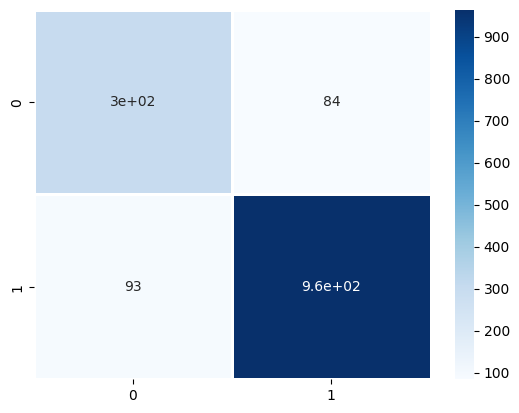

In [14]:
def evaluate(model, x_test, y_test):
    pred = model.predict(x_test)
    acc = accuracy_score(y_test, pred)
    print("ACC: ", acc)
    print(classification_report(y_test,pred))
    return pred



# Trực quan hoá một số thông tin
def visualize_result(model, x_test, y_test):
    y_pred = model.predict(x_test)
    sns.heatmap(confusion_matrix(y_test,y_pred),cmap='Blues',annot=True,linewidths=2,linecolor='white')
    
rfc = RandomForestClassifier(n_estimators=110,max_features='sqrt',max_depth=40)
rfc.fit(X_train,y_train)

pred_rfc = evaluate(rfc, X_test, y_test)
visualize_result(rfc, X_test, y_test)


### Support Vector Machine ( SVM )

ACC:  0.8282548476454293
              precision    recall  f1-score   support

           0       0.63      0.90      0.74       387
           1       0.96      0.80      0.87      1057

    accuracy                           0.83      1444
   macro avg       0.79      0.85      0.80      1444
weighted avg       0.87      0.83      0.84      1444



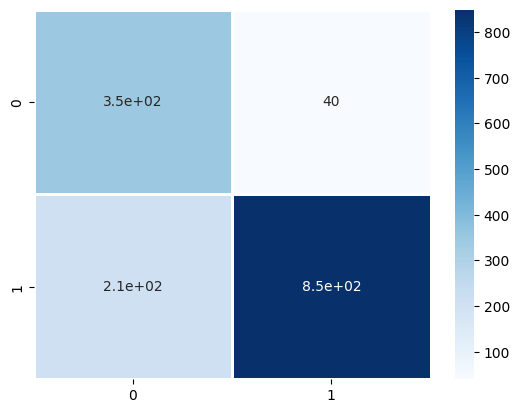

In [15]:
# Scaling the data using standard scaler
from sklearn.preprocessing import MinMaxScaler

sup = SVC(C=2,gamma='auto',kernel='rbf')
sup.fit(X_train,y_train)

pred_svm = evaluate(sup, X_test, y_test)
visualize_result(sup, X_test, y_test)

### Logistic Regression

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ACC:  0.8164819944598338
              precision    recall  f1-score   support

           0       0.61      0.89      0.72       387
           1       0.95      0.79      0.86      1057

    accuracy                           0.82      1444
   macro avg       0.78      0.84      0.79      1444
weighted avg       0.86      0.82      0.83      1444



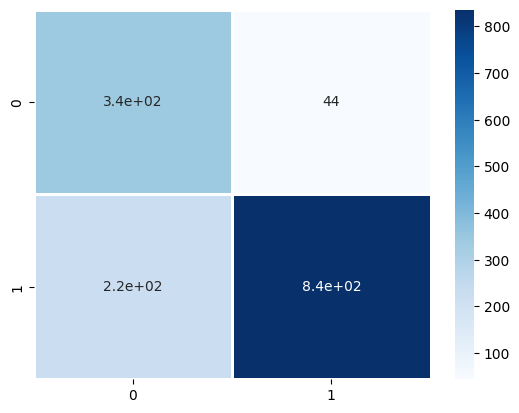

In [16]:
from sklearn.linear_model import LogisticRegression
    
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
pred_clf = evaluate(clf, X_test, y_test)
visualize_result(clf, X_test, y_test)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# Convert dataframes to numpy arrays
X_test_np = np.array(X_test)
test_df_np = np.array(test_df)
a = test_df_np[:, 35]

# Initialize lists to store indices of wrong predictions
wrong_index_rfc, wrong_index_svm, wrong_index_clf = [], [], []

# Populate the lists with indices where the prediction was wrong
for i in range(a.shape[0]):
    if pred_rfc[i] == 1 and a[i] == "Churned":
        wrong_index_rfc.append(i)
    if pred_svm[i] == 1 and a[i] == "Churned":
        wrong_index_svm.append(i)
    if pred_clf[i] == 1 and a[i] == "Churned":
        wrong_index_clf.append(i)

# Print the lists of wrong indices
print("RandomForestClassifier wrong indices:", wrong_index_rfc)
print("SVM wrong indices:", wrong_index_svm)
print("Classifier wrong indices:", wrong_index_clf)

# Create sets from the lists of indices
set_rfc = set(wrong_index_rfc)
set_svm = set(wrong_index_svm)
set_clf = set(wrong_index_clf)

# Plot Venn diagram
plt.figure(figsize=(10, 7))
venn3([set_rfc, set_svm, set_clf], ('RandomForestClassifier', 'SVM', 'Classifier'))
plt.title("Venn Diagram of Wrong Predictions")
plt.show()


In [117]:
X_test_wrong_rfc = test_df_ori.loc[wrong_index_rfc]
X_test_wrong_rfc.head()


,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status
69,7854-EDSSA,Male,46,No,0,Santa Rosa,95404,38.526941,-122.709096,0.0,...,Month-to-Month,No,Bank Withdrawal,59.00,1254.70,0.0,0,1087.46,2342.16,Churned
92,7881-INRLC,Male,34,No,0,San Mateo,94403,37.538309,-122.305109,0.0,...,Month-to-Month,Yes,Credit Card,100.85,4740.00,0.0,0,635.40,5375.40,Churned
116,7927-AUXBZ,Female,45,No,0,Sun City,92586,33.707483,-117.200006,0.0,...,Month-to-Month,No,Bank Withdrawal,85.15,2555.90,0.0,0,280.20,2836.10,Churned
133,7957-RYHQD,Female,65,No,0,Bellflower,90706,33.887676,-118.127289,0.0,...,Month-to-Month,Yes,Credit Card,79.20,3233.85,0.0,0,1794.40,5028.25,Churned
171,8008-HAWED,Male,38,No,0,Los Angeles,90027,34.127194,-118.295647,0.0,...,Month-to-Month,Yes,Bank Withdrawal,50.75,712.75,0.0,0,0.00,722.75,Churned
